In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_orig()

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import Draw

import networkx as nx

from utils.graph_utils import *
from dataset.preprocess import *
from predict_logp.predict_logp import *
import torch_geometric as pyg

In [2]:
def read_data(dataset_path):
    all_logp = []
    all_smiles = []
    with open(dataset_path, newline='') as csvfile:
        reader = csv.reader(csvfile)

        for i, (logp, smiles) in enumerate(reader):
            # Some fields are empty, if logp is empty it will be caught by the exception. If smile is empty, conditional kicks in.
            try:
                if smiles is not None:
                    all_logp.append(float(logp))
                    all_smiles.append(smiles)
                else:
                    continue
            except:
                print("Row " + str(i) + "was not read.")
                continue
    return all_logp, all_smiles

In [3]:
scores, smiles = read_data("/Users/ADChen/Downloads/MD/2col/NSP15_6W01_A_1_F.Orderable_zinc_db_enaHLL.2col.csv")

Row 5834418was not read.
Row 5834419was not read.


In [4]:
train_data, valid_data, test_data = create_datasets(scores, smiles)
test_labels = np.array(test_data.logp)

In [5]:
test_loader = DataLoader(test_data,
                         collate_fn=my_collate,
                         batch_size=1,
                         num_workers=24)

In [6]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda:' + str(args.gpu))
else:
    DEVICE = 'cpu'
print(DEVICE)

cpu


In [7]:
model = torch.load("/Users/ADChen/Downloads/best_model.pth", map_location = DEVICE)

/Users/ADChen/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/ADChen/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/ADChen/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU

In [8]:
model

GNN_MyGAT(
  (layers): ModuleList(
    (0): MyGATConv(121, 512, heads=1)
    (1): MyGATConv(512, 512, heads=1)
    (2): MyGATConv(512, 512, heads=1)
    (3): MyGATConv(512, 512, heads=1)
    (4): MyGATConv(512, 512, heads=1)
    (5): MyGATConv(512, 512, heads=1)
    (6): MyGATConv(512, 512, heads=1)
  )
  (final_layer): Linear(in_features=512, out_features=1, bias=True)
  (act): ReLU()
)

In [9]:
len(test_loader)

1166893

In [10]:
len(test_data)

1166893

In [11]:
# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [12]:
model.layers[6].register_forward_hook(get_activation('GATConv6'))

In [13]:
((len(test_loader)//1000) + 1)

1167

In [34]:
nrows = ((len(test_loader)//1000) + 1)
mol_activations = np.empty((nrows,512))
with torch.no_grad():
    for j, (g1, y, g2) in enumerate(test_loader):
        if j % 1000 == 0:
            g1 = g1.to(DEVICE)
            g2 = g2.to(DEVICE)
            y_pred = model(g1, 0).cpu()
            sum_nodes = np.sum(activation['GATConv6'].numpy(), axis = 0)
            mol_activations[j//1000] = sum_nodes
            break

In [35]:
type(g1), type(g2)

(torch_geometric.data.batch.Batch, torch_geometric.data.batch.Batch)

In [36]:
g1

Batch(batch=[16], edge_attr=[17], edge_index=[2, 17], x=[16, 121])

In [37]:
y_pred

tensor(-10.4787)

In [31]:
g1.batch, g1.edge_attr, g1.edge_index, g1.x

(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([1.0000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.0000, 1.5000, 1.5000,
         1.5000, 1.5000, 1.5000, 1.0000, 2.0000, 1.0000, 1.5000, 1.5000]),
 tensor([[ 0,  1,  2,  3,  4,  5,  5,  7,  8,  9, 10, 11, 12, 13, 13,  6, 12],
         [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,  1,  7]]),
 tensor([[ 0.,  3.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  1.,  ...,  0.,  0.,  0.],
         [ 0.,  1.,  1.,  ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [-1.,  0.,  0.,  ...,  0.,  0.,  0.]]))

In [32]:
g2

Batch(batch=[16], edge_index=[2, 256])

In [33]:
g2.batch, g2.edge_index

(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,  0,  1,
           2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,  0,  1,  2,  3,
           4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,  0,  1,  2,  3,  4,  5,
           6,  7,  8,  9, 10, 11, 12, 13, 14, 15,  0,  1,  2,  3,  4,  5,  6,  7,
           8,  9, 10, 11, 12, 13, 14, 15,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
          10, 11, 12, 13, 14, 15,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
          12, 13, 14, 15,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,
          14, 15,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
           0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,  0,  1,
           2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,  0,  1,  2,  3,
           4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,  0,  1,  2,  3,  4,  5,
           6,  7,  8,  9, 10, 11, 12, 1

In [22]:
g1["x"]

tensor([[ 0.,  3.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  ...,  0.,  0.,  0.],
        [ 0.,  1.,  1.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [-1.,  0.,  0.,  ...,  0.,  0.,  0.]])

In [134]:
mol_activations.shape


(1167, 512)

In [135]:
import umap
from sklearn.preprocessing import StandardScaler

In [136]:
reducer = umap.UMAP()

In [137]:
scaled_gcn_output = StandardScaler().fit_transform(mol_activations)

In [140]:
embedding = reducer.fit_transform(scaled_gcn_output)

In [141]:
scaled_gcn_output.shape

(1167, 512)

In [142]:
embedding.shape

(1167, 2)

In [163]:
len(test_labels) == len(test_loader)

True

In [165]:
dock_scores_umap = []
for j in range(len(test_loader)):
    if j % 1000 == 0:
        dock_scores_umap.append(test_labels[j])

In [206]:
_ = np.percentile(df.dock_score, [0,25,50,75])
_

array([ 5.710984 ,  8.78694  ,  9.374137 , 10.1483845])

In [196]:
df = pd.DataFrame({"UMAP_0":embedding[:,0], "UMAP_1":embedding[:,1], "dock_score": -1*np.array(dock_scores_umap)})

In [210]:
df

,UMAP_0,UMAP_1,dock_score
0,-1.533651,10.753529,3
1,9.533053,11.864703,4
2,-1.660560,10.633651,3
3,8.128553,12.272662,2
4,7.768864,11.748845,3
...,...,...,...
1162,5.545959,10.954579,2
1163,6.085793,12.578204,3
1164,1.623173,12.531706,1
1165,15.823210,4.895302,1


In [209]:
df.dock_score = 1*(df.dock_score > _[-1]) + 1*(df.dock_score > _[-2]) + 1*(df.dock_score > _[-3]) + 1*(df.dock_score > _[-4])

Text(0.5, 1.0, 'UMAP Projection of Last Activation Layer')

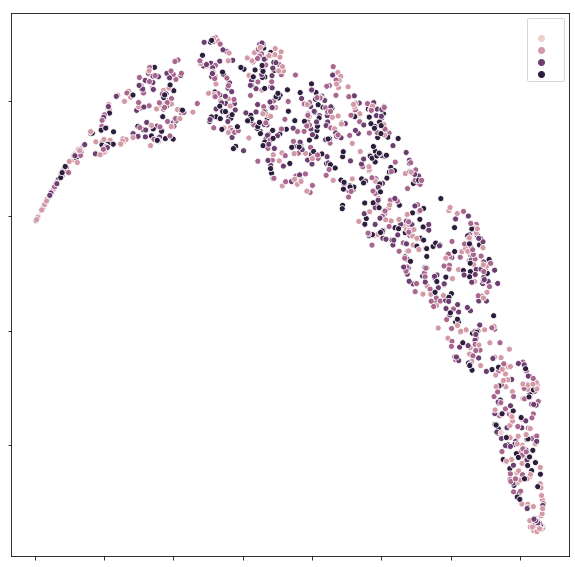

In [216]:
f, ax = plt.subplots(figsize=(10, 10))
ax = sns.scatterplot(x = "UMAP_0", y = "UMAP_1", hue = 'dock_score',  data = df)
ax.set_title("UMAP Projection of Last Activation Layer")